# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Основные шаги:

- Загрузите данные, путь к файлу: /datasets/autos.csv.
- Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
- Подготовьте выборки для обучения моделей.
- Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
- Проанализируйте время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

## Описание данных

Данные находятся в файле /datasets/autos.csv

### Признаки

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYea`r — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Дабы не тратить время на изучение и корректировку данных в неинформативных признаках, мы их сразу удалим:

- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля (так как месяц подготовки проекта не обозначен, месяц не имеет значения, года регистрации будет достаточно)
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

### Целевой признак

- `Price` — цена (евро)

### Примечание

- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.

## 1  Подготовка данных

### Загрузка данных

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install category_encoders

     |████████████████████████████████| 81 kB 2.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Загрузим необходимые библиотеки и функции 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from pandas_profiling import ProfileReport
import time
import re
import warnings
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [4]:
# отключить некритические предупреждения в коде

warnings.filterwarnings("ignore")

In [5]:
# сбросим ограничение на количество выводимых столбцов, что бы просмотреть все столбцы

pd.set_option('display.max_columns', None)

In [6]:
# загрузим файл 
try:
    data = pd.read_csv('C:\\Users\\magas\\Desktop\\Проекты\\autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

**Дабы не тратить время на изучение и корректировку данных в неинформативных признаках, мы их сразу удалим:**

- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля (так как месяц подготовки проекта не обозначен, месяц не имеет значения, года регистрации будет достаточно)
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- PostalCode — дата последней активности пользователя
- LastSeen — дата последней активности пользователя

In [7]:
# Удалим ненужные признаки

delet_columns = ['DateCrawled', 'RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','PostalCode','LastSeen']

data = data.drop(delet_columns, axis=1)

In [8]:
# Также сразу скорректируем названия признаков

data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower()for i in data.columns]
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

### Анализ данных

<div class="alert alert-block alert-success">
<b>Успех:</b> Хороший инструмент)
</div>


Первое, что брасоется в глаза - неправдоподобно низкие показатели в `price` и `power`. 

Также много пропусков в `repaired`. ЛОгично предположить, что пропуск означенет отсутствие ремонтых работ - заполним соотвутствующими значениями.

Вызывают сомнения машины, возрастом более 1000 лет... А также машины путешественников во времени(9999 года регистрации)

Пропуски в `vehicle_type`,`fuel_type`,`gearbox`,`model`, `repaired` заполнить мы не можем, потому просто поменяем на unknown

Еще вопрос к `fuel_type`: petrol b gasoline - одно и тоже. заменим gasoline на petrol, т.к. самый распространенный вариант. А пропуски, скорее всего, машина на бензине, потому и не указано - "это же очевидно, что на блензине"

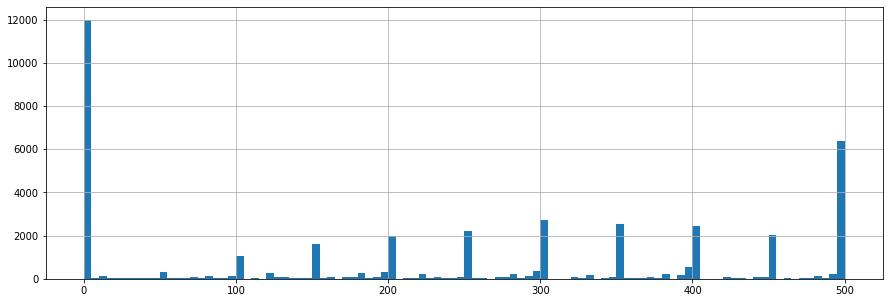

In [9]:
data['price'].hist(bins =100,figsize=(15,5),range=(0,500))
plt.show()

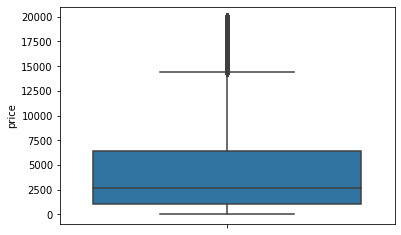

In [10]:
# посмотрим на аномалии в price

sns.boxplot(y='price', data=data)
plt.show()

In [11]:
data[data['price'] < 500]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
15,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
23,450,small,1997,manual,50,arosa,150000,petrol,seat,no
...,...,...,...,...,...,...,...,...,...,...
354318,400,wagon,1991,manual,0,legacy,150000,petrol,subaru,NaN
354329,350,small,1996,NaN,65,punto,150000,NaN,fiat,NaN
354335,390,small,1997,auto,0,corsa,100000,petrol,opel,yes
354338,180,NaN,1995,NaN,0,NaN,125000,petrol,opel,NaN


In [12]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


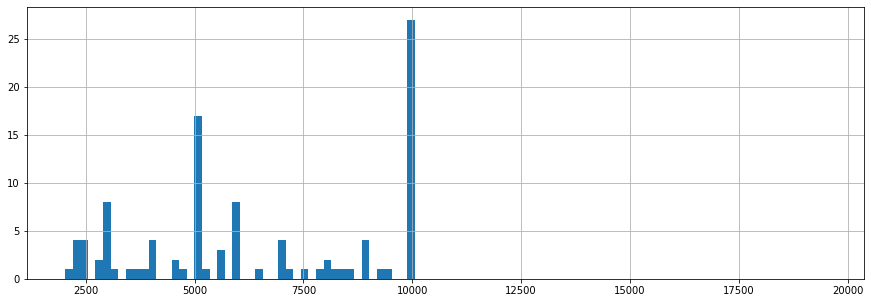

In [13]:
# посмотри на годы регистрации

data['registration_year'].hist(bins =100,figsize=(15,5),range=(2023,19500))
plt.show()

In [14]:
data[data['registration_year'] ==1910]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
15,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN
6629,0,small,1910,NaN,0,NaN,5000,other,sonstige_autos,NaN
6977,135,NaN,1910,NaN,0,NaN,5000,NaN,opel,NaN
10183,1250,NaN,1910,NaN,0,other,5000,NaN,audi,NaN
18023,1,NaN,1910,NaN,0,NaN,5000,NaN,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
331076,0,NaN,1910,NaN,0,NaN,5000,NaN,sonstige_autos,NaN
333004,0,suv,1910,manual,0,NaN,5000,NaN,toyota,NaN
334901,1300,NaN,1910,NaN,0,NaN,5000,NaN,audi,NaN
343083,1,other,1910,NaN,0,NaN,5000,other,volkswagen,NaN


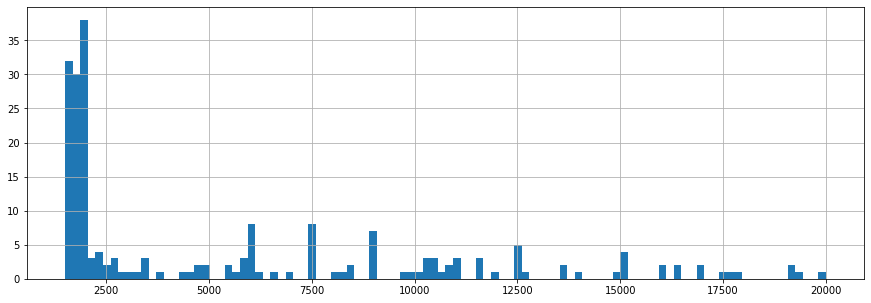

In [15]:
data['power'].hist(bins =100,figsize=(15,5),range=(1500,20000))
plt.show()

В данных много ошибок и нереалистичных данных.

Принято решение удалить все машины стоимостью до 500 евро, мошностью до 5 и более 1500 лс.

Пропуски в `vehicle_type`,`gearbox`,`model`, `repaired` поменяем на unknown

### Обработка данных

In [16]:
# поменяем значения в repaired

data['repaired'].fillna('no', inplace=True)

In [17]:
# поменяем 'gasoline' и пропуски на 'petrol'

data['fuel_type'] = data['fuel_type'].replace('gasoline','petrol')
data['fuel_type'] = data['fuel_type'].fillna('petrol')

In [18]:
# удалим аномалии в price - машины стоимостью меньше 500 евро - нереально (если только не голый кузов)

data = data[data['price'] > 500]

In [19]:
# Самый слабый автомобиль в мире имеет мощность в 5 л.с, самый мощный - 1500л.с.. Но мы ограничим диапозон 50 и 1000 лс - все остальное - явные выбросы или ошибки

data = data[(data['power'] > 50) & (data['power'] <1000)]

In [20]:
data['fuel_type'] = data['fuel_type'].replace('gasoline','petrol')

In [21]:
# ограничим год реистрации с 1930 по 2023

data = data[(data['registration_year'] > 1930) & (data['registration_year'] <2024)]

In [22]:
# заполним пропуски в `vehicle_type`,`fuel_type`,`gearbox`,`model`, `repaired`

columns = ['vehicle_type','gearbox','model'] 

for column in columns:
    
    data[column].fillna('unknown', inplace=True)

### Подготовка данных к обучению

Так как `train_test_split` делит общую выборку только на две части, сначала выделим тестовую часть, затем из оставшейся выделим валидационную.

Тестовая и валидационная выборки должны быть равны и меньше обучающей, потому разделение будет 3/1/1(20% / 20% / 60%)

In [23]:
features = data.drop(['price'], axis=1)
target = data['price']

features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

In [24]:
enc_columns = ['vehicle_type', 'gearbox', 'model','fuel_type', 'brand', 'repaired']

In [25]:
target_encoder = ce.TargetEncoder(cols=enc_columns, handle_unknown=0)

In [26]:
features_train = target_encoder.fit_transform(features_train,target_train)

In [27]:
features_valid = target_encoder.transform(features_valid)

features_test = target_encoder.transform(features_test)

##  Обучение модели

### Линейная регрессия

In [28]:
%%time
lr_model = LinearRegression()

start_time = time.time()
lr_model.fit(features_train,target_train)
training_time = time.time() - start_time

start_time = time.time()
prediction = lr_model.predict(features_valid)
prediction_time = time.time() - start_time


mse = mean_squared_error(target_valid, prediction)
rmse = mse**0.5
print(training_time,prediction_time,rmse )

0.04769611358642578 0.004900693893432617 2857.4316028801272
CPU times: user 40.5 ms, sys: 34.6 ms, total: 75.1 ms
Wall time: 54.2 ms


### LGBMRegressor

In [29]:
%%time
best_rmse = 1e10
best_depth = 0
best_estimators = 0

for n_estimator  in range(10,200,10):
    
    for depth in range(1,5):
        
        lgbm_model  = LGBMRegressor(
            max_depth = depth,
            learning_rate=0.1,
            n_estimators=n_estimator,
            subsample = 0.5)
        
        
        start_time = time.time()
        lgbm_model.fit(features_train,target_train)
        lirning_time = time.time() - start_time
        
         
        start_time = time.time()
        prediction = lgbm_model.predict(features_valid)
        predicting_time = time.time() - start_time
        
        mse = mean_squared_error(target_valid, prediction)
        rmse = mse**0.5
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_depth = depth
            best_estimators = n_estimator
            
print('Время обучения',lirning_time,
      '\nВремя прогнозирования',prediction_time,
      '\nЛучшая глубина:',best_depth,
      '\nЛучшее кол-во деревьев:',best_estimators,
      '\nЛучший результат',best_rmse )

Время обучения 3.994645595550537 
Время прогнозирования 0.004900693893432617 
Лучшая глубина: 4 
Лучшее кол-во деревьев: 190 
Лучший результат 1754.6003238325618
CPU times: user 2min 44s, sys: 314 ms, total: 2min 44s
Wall time: 2min 47s


### Случайный лес

In [30]:
%%time
best_rmse = 1e10
best_depth = 0
best_estimators = 0

for n_estimator  in range(10,50,10):
    
    for depth in range(1,3):
        
        rf_model = RandomForestRegressor(
            n_estimators=n_estimator, 
            max_depth=depth, 
            random_state=42)
        
        start_time = time.time()
        rf_model.fit(features_train,target_train)
        lirning_time = time.time() - start_time
        
        
        start_time = time.time()
        prediction = rf_model.predict(features_valid)
        predicting_time = time.time() - start_time
        
        mse = mean_squared_error(target_valid, prediction)
        rmse = mse**0.5
        
        if rmse < best_rmse:
                best_rmse = rmse
                best_depth = depth
                best_estimators = n_estimator

print('Время обучения',lirning_time,
      '\nВремя прогнозирования',prediction_time,
      '\nЛучшая глубина:',best_depth,
      '\nЛучшее кол-во деревьев:',best_estimators,
      '\nЛучший результат',best_rmse )

Время обучения 2.0910403728485107 
Время прогнозирования 0.004900693893432617 
Лучшая глубина: 2 
Лучшее кол-во деревьев: 10 
Лучший результат 3308.7412764505125
CPU times: user 8.38 s, sys: 16.3 ms, total: 8.39 s
Wall time: 8.46 s


### Итог

Мы обучили 3 модели:

- Модель линейной регрессии - RMSE  2857.431602880133
- Модель LGBMRegressor - RMSE 1754.6003238325618
- Модель случайного леса - RMSE 3308.7412764505125

все модели обучались менее 10 минут, потому главным критерием считаем RMSE

Как видим, лучше всех себя показала LGBMRegressor - ее и будем тестировать


## 3 Анализ модели

In [31]:
%%time

lgbm_model  = LGBMRegressor(
            max_depth = 4,
            learning_rate=0.1,
            n_estimators=190,
            subsample = 0.5)
        
        
start_time = time.time()
lgbm_model.fit(features_train,target_train)
lirning_time = time.time() - start_time


start_time = time.time()
prediction = lgbm_model.predict(features_test)
predicting_time = time.time() - start_time
        
mse = mean_squared_error(target_test, prediction)
rmse = mse**0.5

print(training_time,prediction_time,rmse )

0.04769611358642578 0.004900693893432617 1765.06694554966
CPU times: user 4.65 s, sys: 11.9 ms, total: 4.66 s
Wall time: 4.73 s


Результат более чем хороший. Время обучения и предсказания очень маленькое - менее 2 секунд на обучение и предсказание, при этом результат - 1765.06694554966. результаты на валидационной и тестовой выборке почти одинаковые, что говорит о том, что модель не переобучилась.

## 4 Итог 

По ходу проекта были выполнены следующие шаги:

Изучение и предобработка данных:

- вывели информацию по всем таблицами столбцам
- проверии и устранили пропуски и аномалии
- скорректировали и подогнали выборки для последующих исследований

Создание и обучение моделей:

- Создали три модели и обучили на тренировочной выборке
- Проверили работу моделей на валидационной выборке
- оценили модели и выбрали самую реультативную
Анализ модели:
    
- протестировали модель на тестовой выборке

По итогу проекта лучшей оказалась LGBMRegressor: она хорошо показала себя на валидации, показав хорошее время и сразу выдав необходимый минимум RMSE.
Хорошо себя показала на тесте, повторив результат.

Также хотелось бы обратить внимание на данные: возможно, что аномалии связаны с ошибкой выгрузки, но, скорее всего,есть проблемы с заполнение данных по автомобилю при публикации  - рекомендую скорректировать анкету, исключив возможность указания неправдоподобных данных, а так же реализовать автоматическое заполнение не указанных клиентом пунктов